# 4. Image Classification with CNN

## 4.1 Basic Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [2]:
# 픽시프가 필요하니 설치해주자.
#!pip install piexif

## 4.2 Business Understading

오늘은 CNN을 활용한 딥러닝 모델을 통해서 이미지를 분류해보자.

## 4.3 Dataset

마이크로소프트사에서 받을 수 있다.

https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

압축을 푼 다음에 PetImages 폴더를 해당 프로젝트 아래에 있는 Dataset 폴더로 복사한다. 즉 Project/Dataset/PetImages 가 된다.

## 4.8 Dataset of Cats and Dogs

In [3]:
import os
import random
#!pip install Pillow
import PIL

In [4]:
# 파일명 리스트를 가져옵니다.

_, _, cat_images = next(os.walk("ImageDataset\PetImages\Cat"))

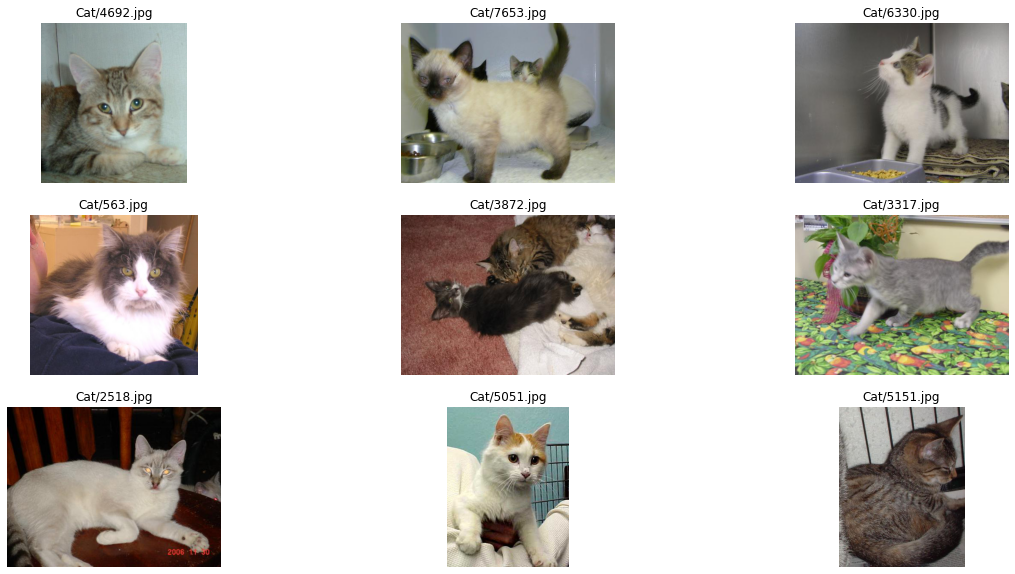

In [5]:
# 가로 세 개, 세로 세 개(총 아홉개) 짜리 차트를 준비합니다.

fig, ax = plt.subplots(3,3, figsize=(20,10))

# 무작위로 선택한 이미지로 차트를 구성합니다.

for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread("ImageDataset\PetImages\Cat/"+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Cat/' +img)

plt.show()

개 이미지도 가져와봅니다.

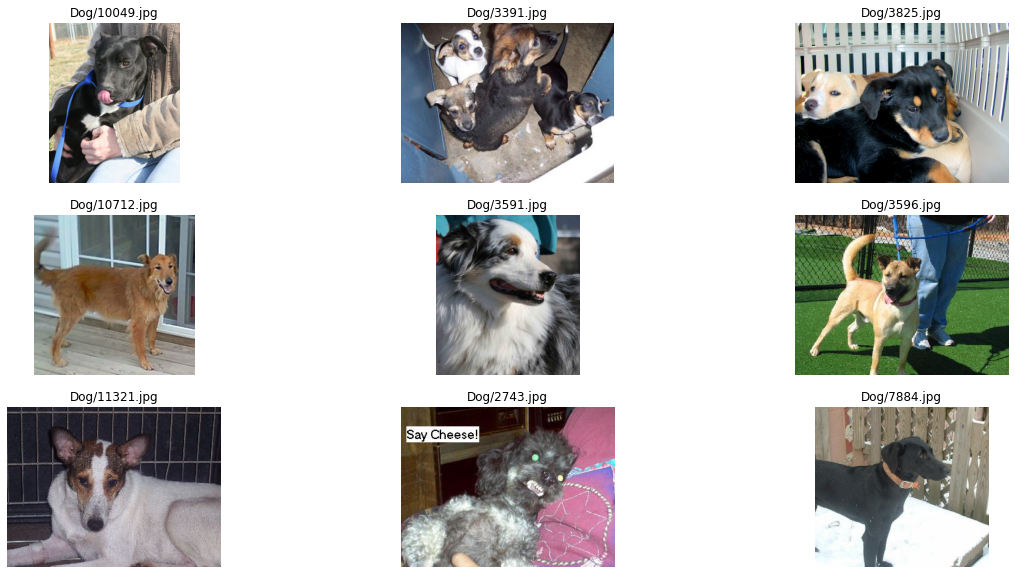

In [6]:
# 가로 세 개, 세로 세 개(총 아홉개) 짜리 차트를 준비합니다.

fig, ax = plt.subplots(3,3, figsize=(20,10))

# 무작위로 선택한 이미지로 차트를 구성합니다.

for idx, img in enumerate(random.sample(cat_images, 9)):
    img_read = plt.imread("ImageDataset\PetImages\Dog/"+img)
    ax[int(idx/3), idx%3].imshow(img_read)
    ax[int(idx/3), idx%3].axis('off')
    ax[int(idx/3), idx%3].set_title('Dog/' +img)

plt.show()

너무 귀엽습니다

## 4.9 Handling Image Data with Keras

신경망으로 이미지 분류 모델을 만들 때 모든 이미지 데이터를 로드할 만큼 컴퓨팅 파워가 되지 않는 경우가 많다고 한다.

이런 문제를 완화하기 위해서 케라스에서는 flow_from_directory 메서드를 지원한다고 한다.

이 메서드에 이미지 폴더 경로를 입력하면 데이터를 필요한 만큼 일정 크기로 나눠 메모리에 로드할 수 있다.

그러나 이 메서드를 사용하려면 정해진 폴더 구조로 준비해야 한다.

따로 하위 디렉터리로 훈련 데이터셋과 테스트 데이터셋을 만들고, 각 데이터셋 아래에 클래스별 하위 디렉터리를 만들어야 한다.

1. /Train/Cat 폴더, /Train/Dog 폴더, /Test/Cat 폴더, /Test/Dog 폴더를 각각 생성.
2. 이미지의 80%를 무작위로 골라 훈련이미지 할당, 나머지 20% 테스트 이미지 할당.
3. 이미지를 각 폴더에 복사.

In [17]:
import os
import random
import shutil
import piexif

def train_test_split(src_folder, train_size = 0.8):
	# Make sure we remove any existing folders and start from a clean slate
	shutil.rmtree(src_folder+'Train/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Train/Dog/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Cat/', ignore_errors=True)
	shutil.rmtree(src_folder+'Test/Dog/', ignore_errors=True)

	# Now, create new empty train and test folders
	os.makedirs(src_folder+'Train/Cat/')
	os.makedirs(src_folder+'Train/Dog/')
	os.makedirs(src_folder+'Test/Cat/')
	os.makedirs(src_folder+'Test/Dog/')

	# Get the number of cats and dogs images
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	files_to_be_removed = ['Thumbs.db', '666.jpg', '835.jpg']
	for file in files_to_be_removed:
		cat_images.remove(file)
	num_cat_images = len(cat_images)
	num_cat_images_train = int(train_size * num_cat_images)
	num_cat_images_test = num_cat_images - num_cat_images_train

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	files_to_be_removed = ['Thumbs.db', '11702.jpg']
	for file in files_to_be_removed:
		dog_images.remove(file)
	num_dog_images = len(dog_images)
	num_dog_images_train = int(train_size * num_dog_images)
	num_dog_images_test = num_dog_images - num_dog_images_train

	# Randomly assign images to train and test
	cat_train_images = random.sample(cat_images, num_cat_images_train)
	for img in cat_train_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Train/Cat/')
	cat_test_images  = [img for img in cat_images if img not in cat_train_images]
	for img in cat_test_images:
		shutil.copy(src=src_folder+'Cat/'+img, dst=src_folder+'Test/Cat/')

	dog_train_images = random.sample(dog_images, num_dog_images_train)
	for img in dog_train_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Train/Dog/')
	dog_test_images  = [img for img in dog_images if img not in dog_train_images]
	for img in dog_test_images:
		shutil.copy(src=src_folder+'Dog/'+img, dst=src_folder+'Test/Dog/')

	# remove corrupted exif data from the dataset
	remove_exif_data(src_folder+'Train/')
	remove_exif_data(src_folder+'Test/')

# helper function to remove corrupt exif data from Microsoft's dataset
def remove_exif_data(src_folder):
	_, _, cat_images = next(os.walk(src_folder+'Cat/'))
	for img in cat_images:
		try:
			piexif.remove(src_folder+'Cat/'+img)
		except:
			pass

	_, _, dog_images = next(os.walk(src_folder+'Dog/'))
	for img in dog_images:
		try:
			piexif.remove(src_folder+'Dog/'+img)
		except:
			pass


In [19]:
#src_folder = 'ImageDataset/PetImages/'
#train_test_split(src_folder)

# 시간이 조금 걸릴겁니다.

## 4.10 Augmenting of Images

이미지 증강은 이미지 분류 모델을 만드는데 필요한 핵심 기법으로, 이미지를 약간 변형해 새로운 훈련 이미지를 만든다. 방법은 이렇다.

- 이미지를 회전시킨다.
- 이미지를 움직인다.
- 좌우를 반전시킨다.
- 이미지를 확대한다.

이미지 데이터는 수집하기 어렵기 때문에 인위적으로 만들어준다.

케라스에서는 ImageDataGenerator 클래스를 사용해 이미지 증강을 할 수 있다.

In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
image_generator = ImageDataGenerator(rotation_range = 30,
                                    width_shift_range = 0.2,
                                    height_shift_range = 0.2,
                                    zoom_range = 0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

무작위 이미지를 선택해서 증강해봅시다.

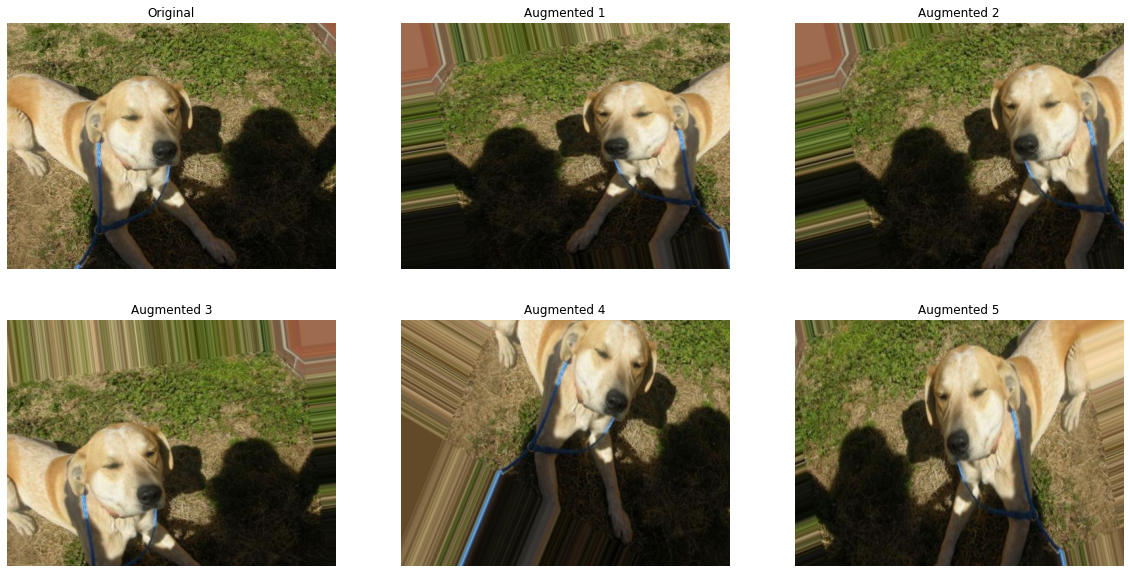

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
all_images = []

_, _, dog_images = next(os.walk("ImageDataset\PetImages\Train\Dog/"))
random_img = random.sample(dog_images, 1)[0]
random_img = plt.imread("ImageDataset\PetImages\Train\Dog/" + random_img)
all_images.append(random_img)

random_img = random_img.reshape((1, ) + random_img.shape)
sample_augmented_images = image_generator.flow(random_img)

for _ in range(5):
    augmented_imgs = sample_augmented_images.next()
    for img in augmented_imgs:
        all_images.append(img.astype('uint8'))
        
for idx, img in enumerate(all_images):
    ax[int(idx/3), idx%3].imshow(img)
    ax[int(idx/3), idx%3].axis('off')
    if idx == 0:
        ax[int(idx/3), idx%3].set_title("Original")
    else:
        ax[int(idx/3), idx%3].set_title("Augmented {}".format(idx))
        
plt.show()

## 4.11 Modeling

CNN의 아키텍쳐는 기본적으로 이렇게 이해하면 된다.

1. 인풋 넣는다.
2. 1차 컨볼루션 레이어로 특정 부위를 뽑는다.
3. 1차 맥스풀링 레이어로 가장 큰 값들을 뽑아낸다.

4. 그걸 다시 2차 컨볼루션 레이어로 넣어 특정 부위를 뽑는다.
5. 그걸 다시 2차 맥스풀링 레이어로 가장 큰 값들을 뽑아낸다.

6. 덴스 레이어로 학습한다.
7. 또 학습 할 수도 있다.

8. 출력한다.

아무튼 핵심은 컨볼루션-맥스풀링 세트로 이어진다는 것이다.

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

In [9]:
# 먼저 골격 잡습니다.

model = Sequential()

컨볼루션 레이어를 추가하기 전에 초매개변수를 먼저 설정해줍니다.

In [10]:
FILTER_SIZE = 3 # 필터 크기. 최근에 등장한 CNN은 대부분 가로3, 세로3 짜리 작은 필터를 사용한다.
NUM_FILTERS = 32 # 훈련 속도와 예측 성능의 균형을 맞출 수 있게 32로 지정.
INPUT_SIZE = 32 # 이미지 크기를 32*32로 지정한다. 원본 이미지보다 압축되어 일부 정보가 소실되지만 학습 속도는 빨라진다.
MAXPOOL_SIZE = 2 # 최대 풀링 크기. 일반적으로 가로2, 세로2 크기로 지정해 입력 레이어의 차원을 반으로 줄인다.
BATCH_SIZE = 16 # 배치 사이즈는 알 것이다. 옵티마이저가 갱신하는 회당 훈련 수. 16개 학습하면 갱신한다.
STEPS_PER_EPOCH = 20000//BATCH_SIZE # 에폭당 반복 수. 일반적으로 훈련 데이터셋 개수를 일괄 처리량으로 나눈 값을 사용한다. 
EPOCHS = 10 # 전체 훈련 데이터 반복 학습 횟수. 10으로 한다.

In [11]:
# 레이어를 쌓아보자.

model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), # 필터수와 필터 사이즈를 지정해준다. 32,(3, 3)
                input_shape = (INPUT_SIZE, INPUT_SIZE, 3), # 인풋 쉐잎은 32*32,3 -> 여기서 3인 이유는 컬러라서 3채널이겠지?
                activation = 'relu')) # 활성화함수는 역시 렐루

# 이어서 맥스풀링 레이어 추가.
model.add(MaxPool2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE))) # 2,2 로 맥스풀링 사이즈 지정

# 위 두 레이어 세트 한 번 더 반복
model.add(Conv2D(NUM_FILTERS, (FILTER_SIZE, FILTER_SIZE), activation = 'relu')) # 두번째라 인풋 없습니다.
model.add(MaxPool2D(pool_size = (MAXPOOL_SIZE, MAXPOOL_SIZE)))

덴스 레이어를 추가하기 전에 입력 벡터의 차원을 줄여야한다고 한다. 케라스의 Flatten 함수를 사용하면 다차원 벡터를 1차원 벡터로 변환할 수 있다. 예를 들어 (5,5,3) 인 벡터를 (75) 인 벡터로 반환한다.

In [12]:
model.add(Flatten()) # 아주 쉽다..갓라스...

# 여기에 덴스 레이어 추가.
model.add(Dense(units = 128, activation='relu'))

마지막 남은 덴스 레이어를 연결하기 전에 드롭아웃 레이어를 연습해본다.

드롭아웃 레이어는 입력값 중 일정 비율을 무작위로 골라 0으로 만든다. 이는 모델이 특정 가중치에 너무 치중하는 걸 막아 과적합을 줄이는 효과가 있다.

In [13]:
# 가중치 중 50% 를 0으로 만든다.

model.add(Dropout(0.5))

# 이제 마지막 레이어 추가.
model.add(Dense(units=1, activation='sigmoid')) # 출력값은 1이고, 마지막 아웃풋은 역시 시그모이드.

옵티마이저는 adam, 로스함수는 바이너리_크로스엔트로피, 메트릭스는 정확도로 가겠다.

In [14]:
model.compile(optimizer='adam', # SGD를 일반화한 알고리즘이다.
             loss='binary_crossentropy', # 개와 고양이를 분류하는 이진분류이므로 바이너리.
             metrics=['accuracy'])

이제 모델을 다 완성했다. 훈련만 시키면 되는데, 아까 말했던 flow_from_directory 메서드를 사용해 실시간으로 모델을 훈련시킨다.

 DNN과 다르게 CNN은 fit_generator를 쓰는데, x와 y데이터를 그대로 집어 넣어주는 것이 아니라 중간 브로커를 넣는다고 생각하면 된다. 창고지기랄까.
 
 fit_generator를 호출하면 자기가 지정해 둔 이미지 창고에 가서 이미지를 찾아 넘겨준다.

In [15]:
import PIL
from PIL import Image

In [16]:
training_data_generator = ImageDataGenerator(rescale = 1./255)

# fit_generator 에 집어 넣을 창고지기를 지정한다.
training_set = training_data_generator.flow_from_directory('ImageDataset/PetImages/Train/',
                                                           target_size = (INPUT_SIZE, INPUT_SIZE),
                                                           batch_size = BATCH_SIZE,
                                                           class_mode = 'binary')

# 창고지기를 통해서 fit을 한다.
model.fit_generator(training_set, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, verbose=1)

Found 19997 images belonging to 2 classes.
Epoch 1/10
1250/1250 [==============================] - 153s 122ms/step - loss: 0.6315 - accuracy: 0.6375
Epoch 2/10
1250/1250 [==============================] - 130s 104ms/step - loss: 0.5534 - accuracy: 0.7161 - loss: 0.553
Epoch 3/10
1250/1250 [==============================] - 128s 102ms/step - loss: 0.5042 - accuracy: 0.7555
Epoch 4/10
1250/1250 [==============================] - 129s 103ms/step - loss: 0.4725 - accuracy: 0.7749
Epoch 5/10
1250/1250 [==============================] - 126s 101ms/step - loss: 0.4456 - accuracy: 0.7902
Epoch 6/10
1250/1250 [==============================] - 137s 110ms/step - loss: 0.4232 - accuracy: 0.8036
Epoch 7/10
1250/1250 [==============================] - 130s 104ms/step - loss: 0.4017 - accuracy: 0.8150
Epoch 8/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.3794 - accuracy: 0.8285
Epoch 9/10
1250/1250 [==============================] - 98s 79ms/step - loss: 0.3600 - accuracy:

In [18]:
testing_data_generator = ImageDataGenerator(rescale = 1./255)

test_set = testing_data_generator.flow_from_directory('ImageDataset/PetImages/Test/',
                                                           target_size = (INPUT_SIZE, INPUT_SIZE),
                                                           batch_size = BATCH_SIZE,
                                                           class_mode = 'binary')

score = model.evaluate_generator(test_set, steps=len(test_set))
for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

Found 5000 images belonging to 2 classes.
loss: 0.15737609565258026
accuracy: 0.781000018119812


### 4.11.2 Transfer Learning

전이학습을 통해 CNN의 성능을 끌어올릴 수 있다.

전이학습은 특정 대상을 예측하게 훈련시킨 모델을 다른 대상도 예측할 수 있게 바꾸는 머린 러닝 기법이다.

간단히 비유하면 복싱하던 친구를 킥복싱 선수로 내보내는 것이다.

우리는 ILSVRC대회에서 뛰어난 성적을 보여준 VGG16 모델을 출전시킬 것이다.

In [8]:
from keras.applications.vgg16 import VGG16

In [9]:
INPUT_SIZE = 48 # 코드 실행이 너무 오래 걸린다면 이 값을 48로 변경하자, 원래는 128이다.
vgg16 = VGG16(include_top=False, # VGG16 맨 끝의 Dense레이어를 로드하지 않는다는 명령이다.
              weights='imagenet',
              input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

우리는 VGG16모델을 처음부터 학습시키지 않으므로 나머지 레이어를 고정해야 한다. 코드는 다음과 같다.

In [10]:
for layer in vgg16.layers:
    layer.trainable = False

그런 다음 신경망 맨 오른쪽에 한 개짜리 Dense 레이어를 추가한다. VGG16은 케라스 Sequential 모델로 만들지 않는다.

In [11]:
from keras.models import Model

In [12]:
input_ = vgg16.input
output_ = vgg16(input_)
last_layer = Flatten(name='flatten')(output_)
last_layer = Dense(1, activation='sigmoid')(last_layer)
model = Model(input=input_, output=last_layer)

C:\Users\thinp\anaconda3\envs\Wyatt37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


이제 나머지 코드는 비슷하다. flow_from_directory 메서드로 데이터셋을 가져온 다음 모델을 훈련시킨다.

In [13]:
# 초매개변수 정의
BATCH_SIZE = 16
STEPS_PER_EPOCH = 200
EPOCHS = 3

In [14]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics = ['accuracy'])

In [17]:
training_data_generator = ImageDataGenerator(rescale = 1./255)
testing_data_generator = ImageDataGenerator(rescale = 1./255)

# fit_generator 에 집어 넣을 창고지기를 지정한다.
training_set = training_data_generator.flow_from_directory('ImageDataset/PetImages/Train/',
                                                           target_size = (INPUT_SIZE, INPUT_SIZE),
                                                           batch_size = BATCH_SIZE,
                                                           class_mode = 'binary')

test_set = testing_data_generator.flow_from_directory('ImageDataset/PetImages/Test/',
                                                      target_size = (INPUT_SIZE, INPUT_SIZE),
                                                      batch_size = BATCH_SIZE,
                                                      class_mode = 'binary')

model.fit_generator(training_set,
                    steps_per_epoch=STEPS_PER_EPOCH,
                   epochs=EPOCHS,
                   verbose=1)

Found 19997 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/3
200/200 [==============================] - 56s 278ms/step - loss: 0.6248 - accuracy: 0.6556
Epoch 2/3
200/200 [==============================] - 60s 300ms/step - loss: 0.5704 - accuracy: 0.7131
Epoch 3/3
200/200 [==============================] - 63s 314ms/step - loss: 0.5456 - accuracy: 0.7272


In [18]:
score = model.evaluate_generator(test_set, steps=len(test_set))

for idx, metric in enumerate(model.metrics_names):
    print("{}: {}".format(metric, score[idx]))

loss: 0.4524953365325928
accuracy: 0.7355999946594238


## 4.12 Result

마지막 아웃풋 레이어의 활성화함수는 시그모이드인데, 얘는 모든 값을 0과 1사이의 값으로 바꿔준다.

즉 0.5를 기준으로 그보다 작으면 고양이, 크면 개로 예측한다는 것이지.

결과를 세 분류로 나눠보자.

- 크게 맞은 결과: 모델이 예측한 값이 0.8초과 혹은 0.2 미만이고 클래스를 잘 분류
- 크게 틀린 결과: 모델이 예측한 값이 0.8초과 혹은 0.2 미만이고 클래스를 잘못 분류
- 근소하게 틀린 결과: 모델이 예측한 값이 0.4에서 0.6 사이고 클래스를 잘못 분류한 경우

In [20]:
import random

In [26]:
# 시각화할 테스트 데이터를 생성한다.
test_set = testing_data_generator.flow_from_directory('ImageDataset/PetImages/Test/',
                                                      target_size = (48, 48),
                                                      batch_size = 1,
                                                      class_mode = 'binary')

strongly_wrong_idx = []
strongly_right_idx = []
weakly_wrong_idx = []

for i in range(test_set.__len__()):
    img = test_set.__getitem__(i)[0]
    pred_prob = model.predict(img)[0][0]
    pred_label = int(pred_prob > 0.5)
    actual_label = int(test_set.__getitem__(i)[1][0])
    if pred_label != actual_label and (pred_prob >0.8 or pred_prob <0.2):
        strongly_wrong_idx.append(i)
    elif pred_label != actual_label and (pred_prob >0.4 or pred_prob <0.6):
        weakly_wrong_idx.append(i)
    elif pred_label == actual_label and (pred_prob >0.8 or pred_prob <0.2):
        strongly_right_idx.append(i)
    # 이미지를 다 가져오면 멈춘다.
    if (len(strongly_wrong_idx)>=9 and len(strongly_right_idx)>=9 and len(weakly_wrong_idx)>=9):
        break

Found 5000 images belonging to 2 classes.


In [27]:
def plot_on_grid(test_set, idx_to_plot, img_size=INPUT_SIZE):
    fig, ax = plt.subplots(3,3, figsize=(20, 10))
    for i, idx in enumerate(random.sample(idx_to_plot, 9)):
        img = test_set.__getitem__(idx)[0].reshape(img_size, img_size, 3)
        ax[int(i/3), i%3].imshow(img)
        ax[int(i/3), i%3].axis('off')

<function matplotlib.pyplot.show(*args, **kw)>

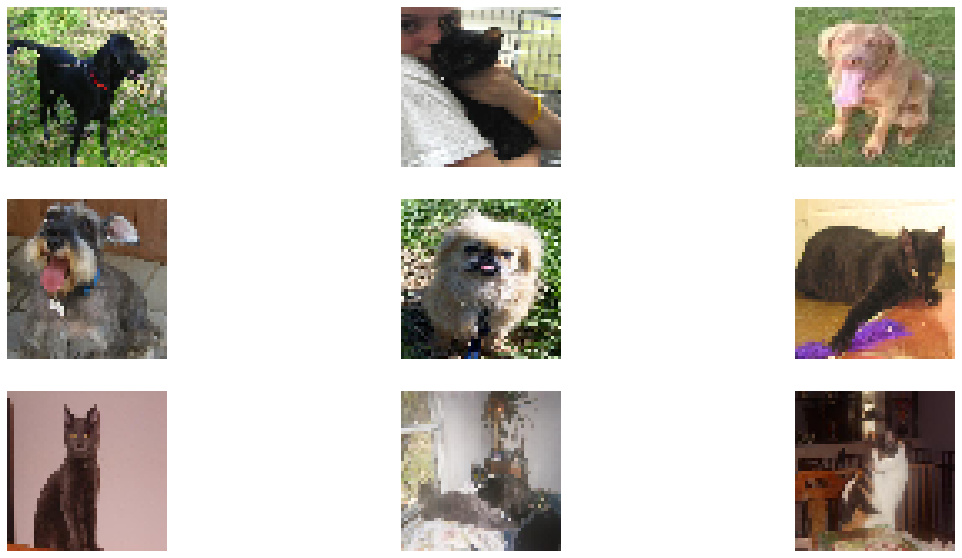

In [28]:
plot_on_grid(test_set, strongly_right_idx)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

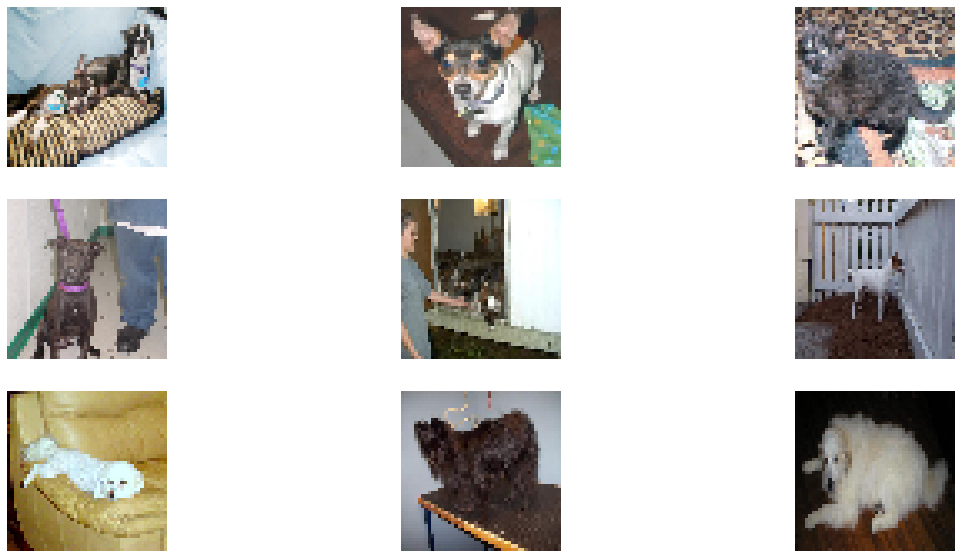

In [29]:
plot_on_grid(test_set, strongly_wrong_idx)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

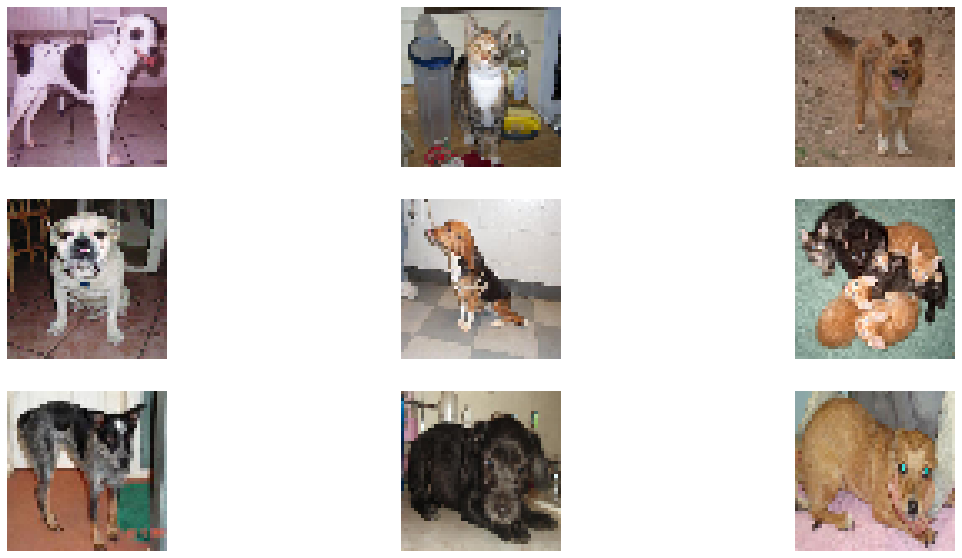

In [30]:
plot_on_grid(test_set, weakly_wrong_idx)
plt.show